In [1]:
from __future__ import division
%pylab inline
import pandas as pd
import os
import json
from collections import defaultdict, Counter
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

# 1. Number of sites per ASN

- Rank ASN by number of sites
- Rank AS name by number of ASNs and number of sites

In [3]:
df_cdn = pd.read_pickle("results/df_cdn.pkl")
df_ip_asn = pd.read_pickle("results/df_ip_asn.pkl")

In [4]:
print(len(df_ip_asn))
print(len(df_cdn))

df_valid_ip = df_ip_asn[df_ip_asn["ip"]!=False]
print(len(df_valid_ip))

500
500
480


### Domains per ASN

#### 480 sites of 500 were resolved to IPs, 20 sites were blocked by ISP
#### 192 individual ASNs. 149 of these only catered to 1 website among 480. 43 ASNs hosted 331 websites
- major_as_names = ["Amazon", "Google", "Microsoft", "Cloudflare", "Fastly", "Facebook", "ChinaNet", "Yahoo", "Akamai", "Alibaba"]
- Including 69 on Google, 41 on Amazon-02, 17 on Amazon-AES, 37 on Cloudflare, 30 on Fastly, 16 on Akamai, 8 on Microsoft, 6 on Yahoo. A total 262 sites on top 10 major ASNs.
- Individual ASNs per AS name: Yahoo 6, ChinaNet 4, Akamai 3, Microsoft 2, Amazon 2, Alibaba 2


In [61]:
df_asn_grouping = df_ip_asn.groupby(["asn", "asname"])['site'].count().sort_values(ascending=False).reset_index()

print("Sites that couldn't be resolved = ", df_asn_grouping[ df_asn_grouping["asn"]==False ]['site'])
df_asn_grouping = df_asn_grouping[ df_asn_grouping["asn"]!=False ]

print("Number of individual ASNs=",len(df_asn_grouping))
print("Number of individual ASNs catering to just 1 website =",len(df_asn_grouping[df_asn_grouping["site"]==1]))
print("Number of individual ASNs catering multiple websites =",len(df_asn_grouping[df_asn_grouping["site"]>1]))
print("Number of websites on ASNs with multiple sites=",sum(df_asn_grouping[df_asn_grouping["site"]>1]['site']))

Sites that couldn't be resolved =  4    20
Name: site, dtype: int64
Number of individual ASNs= 192
Number of individual ASNs catering to just 1 website = 149
Number of individual ASNs catering multiple websites = 43
Number of websites on ASNs with multiple sites= 331


In [69]:
major_as_names = ["Amazon", "Google", "Microsoft", "Cloudflare", "Fastly", "Facebook",
                  "ChinaNet", "Yahoo", "Akamai", "Alibaba"]

def group_as_name(as_name):
    if as_name is not False:
        for m in major_as_names:
            if m.lower() in as_name.lower():
                return m
        return as_name.split(" ")[0].strip(",").strip()
    else:
        return ""

In [66]:
df_asn_grouping["as_grouped"] = df_asn_grouping["asname"].apply(group_as_name)
df_ip_asn['as_grouped'] = df_ip_asn["asname"].apply(group_as_name)

In [68]:
#print(df_asn_grouping.groupby("as_grouped")['asn'].count().sort_values(ascending=False).to_string())
print("Sites on major ASNs = ",len( df_ip_asn[ df_ip_asn["as_grouped"].isin(major_as_names) ] ) )

Sites on major ASNs =  262


In [95]:
print("Number of sites per major AS")
df_ip_asn[ df_ip_asn["as_grouped"].isin(major_as_names) ].groupby('as_grouped')['rank'].count()

Number of sites per major AS


as_grouped
Akamai        21
Alibaba       18
Amazon        58
ChinaNet       9
Cloudflare    37
Facebook       3
Fastly        30
Google        69
Microsoft      8
Yahoo          9
Name: rank, dtype: int64

In [96]:
print("Number of ASN per AS")
df_asn_grouping.groupby('as_grouped')['asn'].count().sort_values(ascending=False).head(7)

Number of ASN per AS


as_grouped
Yahoo        6
ChinaNet     4
Akamai       3
             2
Microsoft    2
Amazon       2
Alibaba      2
Name: asn, dtype: int64

#### Save grouped data

In [98]:
df_ip_asn.to_pickle("results/df_ip_asn_grouped.pkl")

# 2. ASN vs CDN

In [101]:
df_cdn = pd.read_pickle("results/df_cdn_grouped.pkl")

In [151]:
df_ip_asn_cdn = df_cdn.merge(df_ip_asn, on=["rank", "site"])

## ASN == CDN?
- Only 28 websites for which AS name did not match a known CDN name (we're not counting those for which we couldn't find a CDN or unknown CDN urls). This really shouldn't happen frequently as the way CDNs work, they host majority of content on CDN's IP range which should belong to the CDN itself. There is a chance that the website homepage is on a different IP range but all objects on its page are pulled from a different CDN.
- Certain sites using Alibaba CDN but on Taobao ASN and vice-versa. However Taobao is part of Alibaba.
- Instagram known to use Facebook CDN but is on Amazon architecture. Whatsapp uses Facebook CDN but IP range in SoftLayer AS (original creator of Whatsapp). Similar for netflix, when detected from India, the IP is on Amazon's Cloud server but it uses Open-Connect.
- Microsoft websites use Akamai for CDN but registered AS name is Microsoft.
- amazon.cn is on a chinese ASN belonging to China169, but uses Amazon's CDN.
- Many sites using Akamai but have their own AS names.
- Most surprising one was liputan6.com	using Akamai to host most of its resources but on Amazon's ASN.


In [108]:
print("AS name (grouped) == CDN name:", len(df_ip_asn_cdn[ df_ip_asn_cdn["cdn_all"] == df_ip_asn_cdn['as_grouped'] ]))

AS name (grouped) == CDN name: 169


In [145]:
def find_unequal_asname_cdn(vals):
    #print(vals)
    if not vals["cdn_grouped"] in ["NO CDN", "UNKNOWN CDN URL"]:
        if not (vals["as_grouped"].lower() in vals["cdn_all"].lower() or
                vals["as_grouped"].lower() in vals["cdn_grouped"].lower()):
            return True
    return False

            
df_unequal_asn_cdn = df_ip_asn_cdn[ df_ip_asn_cdn.apply(lambda val: find_unequal_asname_cdn(val), axis=1) ]

In [146]:
#df_unequal_asn_cdn = df_ip_asn_cdn[~(df_ip_asn_cdn["cdn_grouped"].isin(["NO CDN", "UNKNOWN CDN URL"])) &
#                                   ~(
#                                       (df_ip_asn_cdn["cdn_all"]==df_ip_asn_cdn['as_grouped']) |
#                                       (df_ip_asn_cdn["cdn_grouped"]==df_ip_asn_cdn['as_grouped'])
#                                   )]

In [147]:
print("AS name != CDN name for known CDNs:", len(df_unequal_asn_cdn))

AS name != CDN name for known CDNs: 28


In [149]:
df_unequal_asn_cdn[["rank", "site", "cdn_all", "cdn_grouped", "as_grouped", "asn"]]

,rank,site,cdn_all,cdn_grouped,as_grouped,asn
8,9,taobao.com,Taobao,KNOWN CDN,Alibaba,37963
18,19,instagram.com,Facebook,KNOWN CDN,Amazon,14618
22,23,login.tmall.com,Alibaba,Alibaba,TAOBAO,24429
26,27,netflix.com,Open-Connect (Netflix),KNOWN CDN,Amazon,16509
45,46,whatsapp.com,Facebook,KNOWN CDN,SOFTLAYER,36351
50,51,naver.com,Akamai,Akamai,NHN-AS-KR,23576
55,56,msn.com,Akamai,Akamai,Microsoft,8075
62,63,wordpress.com,WordPress,KNOWN CDN,AUTOMATTIC,2635
104,105,salesforce.com,Akamai,Akamai,SALESFORCE,14340
116,117,force.com,Akamai,Akamai,ULTRADNS,12008


# Average timing performance of websites across AS groups
- load filtered timing data (df_pass) of successful responses to 45100 requests
- reload grouped df_ip_asn and df_cdn

In [162]:
df_ip_asn = pd.read_pickle('results/df_ip_asn_grouped.pkl')
df_cdn = pd.read_pickle('results/df_cdn_grouped.pkl')

df_cdn_asn = df_cdn.merge(df_ip_asn, on=['rank', 'site'])

In [180]:
asn_to_as_group = {}
major_as_names = ["Amazon", "Google", "Microsoft", "Cloudflare", "Fastly", "Facebook",
                  "ChinaNet", "Yahoo", "Akamai", "Alibaba"]
gp_temp = df_cdn_asn[["asn", "as_grouped"]].groupby("asn")
for asn, as_grp in gp_temp['as_grouped'].unique().to_dict().items():
    if len(as_grp)!=1:
        print (asn, as_grp)
    elif as_grp[0] in major_as_names:
        asn_to_as_group[asn]=as_grp[0]
    elif asn!=False:
        asn_to_as_group[asn]="OTHER AS"
    else:
        asn_to_as_group[asn]=None

In [181]:
df_cdn_asn['major_as'] = df_cdn_asn['asn'].map(asn_to_as_group)

### Load and merge filtered timing data with as groups

In [182]:
df_pass = pd.read_pickle("results/df_pass.pkl")

In [183]:
time_cols = ['time_redirect', 'time_namelookup', 'time_connect',
       'time_appconnect', 'time_pretransfer', 'time_starttransfer',
       'time_total']
t_cols = ['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx', 't_fbyte']

df_avg_time = df_pass.groupby(['rank'])[time_cols+t_cols].mean()

In [184]:
result = df_avg_time.merge(df_cdn_asn, left_index=True, on='rank', how='left')

In [214]:
sum( result.groupby('major_as')['asn'].count() )

449

In [192]:
gp = result.groupby(['asn', 'as_grouped', 'major_as'])
cdn_group_cnt = gp['rank'].count().sort_values(ascending=False)

df_asn_perf = gp[t_cols].mean()
df_asn_perf['count'] = gp['site'].count()

df_asn_perf.head()

,,,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,count
asn,as_grouped,major_as,,,,,,,,
10103,HKBN-AS-AP,OTHER AS,0.103228,0.115992,0.251263,0.000037,0.241221,0.167472,0.711740,1
10361,BLOOMBERG-NET,OTHER AS,0.042648,0.028253,0.070465,0.000100,0.190700,0.000011,0.332166,1
10782,HP-DIGITAL-10782,OTHER AS,0.040851,0.283128,0.601638,0.000035,0.284481,0.000074,1.210132,1
10794,BANKAMERICA,OTHER AS,0.271523,0.281523,0.800233,0.000039,0.509077,1.347542,1.862396,1
1142,WKAPNET,OTHER AS,0.035550,0.028493,0.071610,0.000033,0.317979,0.000019,0.453665,1


## Performance analysis after grouping

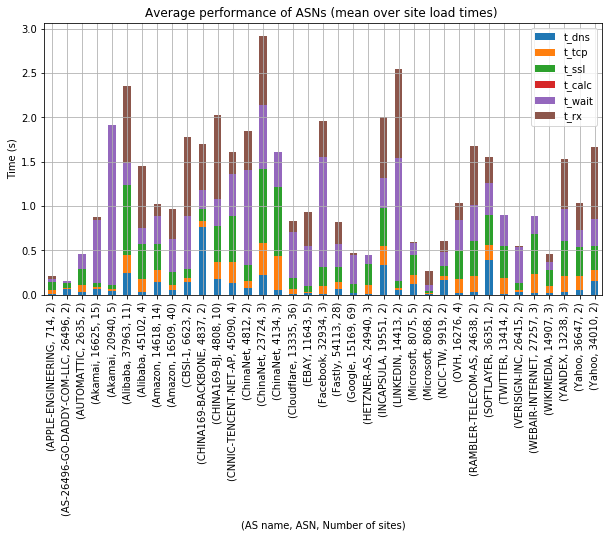

In [209]:
df = df_asn_perf[df_asn_perf['count']>1].reset_index().sort_values(by='as_grouped').set_index(["as_grouped", "asn", "count"])

ax = df[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
ax.set_xlabel("(AS name, ASN, Number of sites)")
ax.set_ylabel("Time (s)")
ax.set_title("Average performance of ASNs (mean over site load times) ")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_asn')

### Grouping ASNs further

In [197]:
gp2 = result.groupby(['major_as'])
cdn_group_cnt2 = gp2['rank'].count().sort_values(ascending=False)

In [210]:
df_cdn_perf2 = gp2[t_cols].mean()
df_cdn_perf2['count'] = gp2['site'].count()
#df_cdn_perf['cdn_grouped'] = df_cdn_perf.index.map(cdn_to_cdn_group)
df_cdn_perf2.sort_values(by='count', inplace=True)

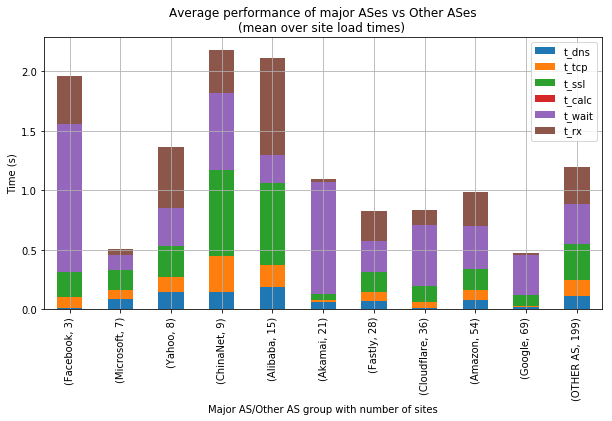

In [211]:
df2 = df_cdn_perf2.reset_index().set_index(["major_as", "count"])

ax = df2[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
ax.set_xlabel("Major AS/Other AS group with number of sites")
ax.set_ylabel("Time (s)")
ax.set_title("Average performance of major ASes vs Other ASes\n(mean over site load times) ")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_majoras_vs_otheras')

In [249]:
df_perf_asn_cdn = result[["rank", "site", "asn", "as_grouped","cdn_all", "cdn_grouped"]+t_cols]

#### AKAMAI

In [250]:
df_akamai = df_perf_asn_cdn[ (df_perf_asn_cdn['as_grouped']=="Akamai") ]

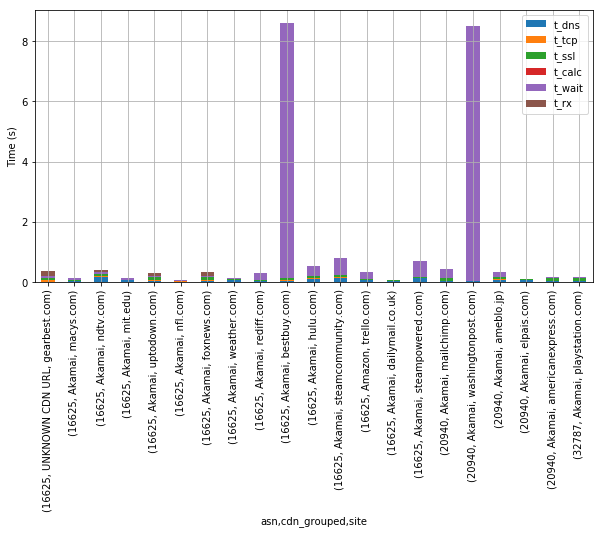

In [257]:
df = df_akamai.sort_values(by='asn').set_index(["asn", "cdn_grouped", "site"])
ax = df[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
#ax.set_xlabel("Akamai")
ax.set_ylabel("Time (s)")
#ax.set_title("Average performance of major ASes vs Other ASes\n(mean over site load times) ")
ax.grid(True)

In [226]:
df_akamai = df_perf_asn_cdn[ (df_perf_asn_cdn['as_grouped']=="Akamai") & ~(df_perf_asn_cdn['rank'].isin([259,262])) ]
df_bad_akamai = df_perf_asn_cdn[ (df_perf_asn_cdn['as_grouped']=="Akamai") & (df_perf_asn_cdn['rank'].isin([259,262])) ]

In [252]:
#df_akamai[df_akamai['asn']=="16625"].describe()

In [253]:
#df_akamai[df_akamai['asn']!="16625"].describe()

In [254]:
#df_bad_akamai.describe()

#### Alibaba

In [255]:
df_alibaba = df_perf_asn_cdn[ (df_perf_asn_cdn['as_grouped']=="Alibaba") ]

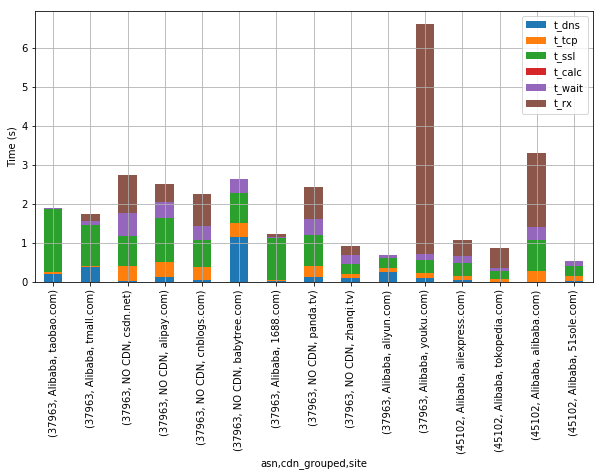

In [258]:
df = df_alibaba.sort_values(by='asn').set_index(["asn", "cdn_grouped", "site"])
ax = df[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
#ax.set_xlabel("Akamai")
ax.set_ylabel("Time (s)")
#ax.set_title("Average performance of major ASes vs Other ASes\n(mean over site load times) ")
ax.grid(True)

In [242]:
df_alibaba.groupby('asn')[t_cols].mean()

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
asn,,,,,,,
37963,0.244858,0.197153,0.797567,0.000084,0.248741,0.861141,1.488402
45102,0.032139,0.145001,0.398432,0.000088,0.178535,0.700748,0.754195


#### Amazon

In [259]:
df_amazon = df_perf_asn_cdn[ (df_perf_asn_cdn['as_grouped']=="Amazon") ]

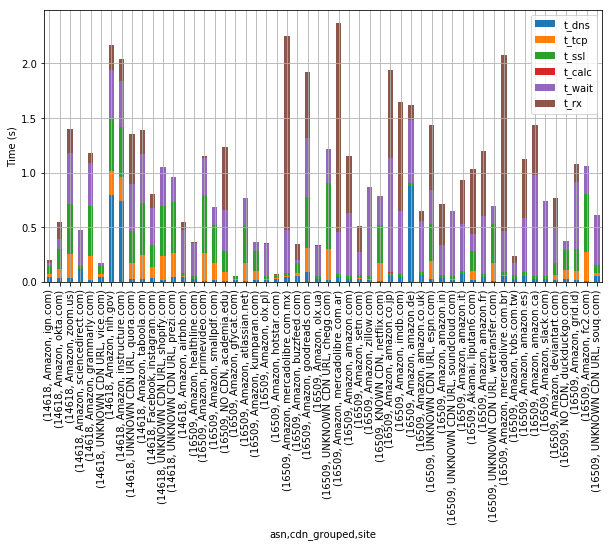

In [260]:
df = df_amazon.sort_values(by='asn').set_index(["asn", "cdn_grouped", "site"])
ax = df[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
#ax.set_xlabel("Akamai")
ax.set_ylabel("Time (s)")
#ax.set_title("Average performance of major ASes vs Other ASes\n(mean over site load times) ")
ax.grid(True)

#### ChinaNet

In [268]:
df_chinanet = df_perf_asn_cdn[ (df_perf_asn_cdn['as_grouped']=="ChinaNet") ]

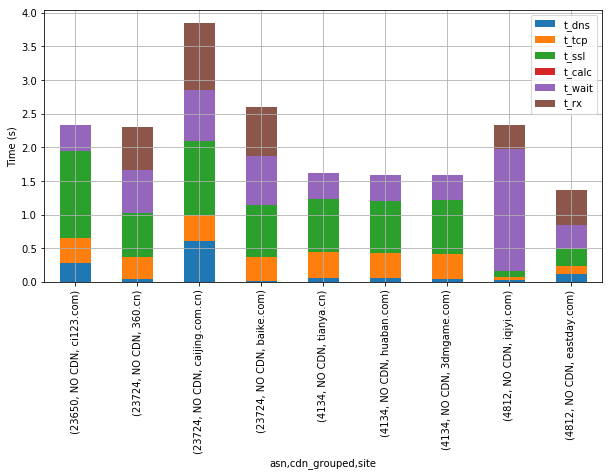

In [269]:
df = df_chinanet.sort_values(by='asn').set_index(["asn", "cdn_grouped", "site"])
ax = df[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
#ax.set_xlabel("Akamai")
ax.set_ylabel("Time (s)")
#ax.set_title("Average performance of major ASes vs Other ASes\n(mean over site load times) ")
ax.grid(True)

In [278]:
#print( df_ip_asn_cdn.groupby(["as_grouped","cdn_grouped"])['site'].count().to_string() )